# SnapChat Filters : Aging

# Introduction

Back in 2012, three apps were released on the Apple App Store - Fatify, Baldify and Oldify. While the results looked decent and the apps were great for fun and giggles, I wondered who would buy the app. Turns out millions of people did and the apps made millions of dollars! 

In this lecture, we will learn how to apply an aging filter to a face. Based on what we have learned so far, you have all the knowledge needed to write an aging filter. 

> So, I want you to pause for 15 minutes and write down how you would go about building an aging filter.

## The Core Idea

Before we design a filter, let’s first think of the various ways age affects the appearance of the face.

<center><a href="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m5-agingImage.png"><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m5-agingImage.png" width=500/></a></center>

1. **Wrinkles:** The most prominent change is perhaps the appearance of wrinkles on the face. 

2. **Spots:** It is very common for brown and black spots to show up on parts of the skin that is exposed to the sun. These spots are called Liver spots even though they have nothing to do with the Liver. 

3. **Paler appearance:** The skin actually appears pale and translucent. 

4. **Lower elasticity:** The skin loses elasticity and sags. 

If we think like a scientist, we will try to reproduce each of these effects on a facial photo. But this is a course for engineers. We will use shortcuts whenever we can! 

A frontal facial photograph of an old person, shown above, exhibits a lot of features related to aging. Can we borrow those features and apply it to our image? Yes, and that is the core idea. 

First, we will warp the wrinkle image to the coordinates of the input images and then perform seamless cloning with MIXED_CLONE option. 

We will go over the steps in the code section. However, there are a few things worth discussing before we dive into the code. 

### How to Estimate Forehead Points

We know that Dlib’s landmark detector does not produce any points on the forehead. For aging application it is very important to have some points on the forehead because forehead wrinkles are important for showing aging. 

There are a few different ways of estimating forehead points. 

1. Train a new landmark detector with points on the forehead. 

2. Estimate the forehead points based on the current landmark points.

Of the two above two methods, the first one is no doubt more elegant, but it requires a large data collection effort. If you were building a commercial application, this may be the right path to take. 
<center><a href="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m5-landmarkPoints.png"><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m5-landmarkPoints.png" width=400/></a></center>
There are a few different ways of using option 2. One can train a linear regressor, that takes as input the current landmark points and outputs the forehead points. To train the linear regressor we need to manually mark forehead landmarks on a few hundred images. 

The final option is to come up with a heuristic that works fine for the application. We guesstimate four forehead points. See figure on the left. 

For each one of them we pick a point on the lower eyelid and another point on the eyebrow and extend the line by a fixed amount to land at our estimate of the forehead point. 





### How to Generate a Mask from Points

Given a set of points on a polygon, we know we can create a mask using fillPoly or fillConvexPoly in OpenCV. 

Facial landmarks do not form a polygon. To find a face mask, we need to find a Convex Hull of all points. 

### What is a Convex hull?
<center><a href="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m5-convexHull.png"><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m5-convexHull.png" width=400/></a></center>

&nbsp;
The image on the left shows a few red points. The blue line is the Convex Hull. The convex hull of has two important properties

1. It is a **convex polygon.** This means that all internal angles are less than 180 degrees. The outer boundary has no concavities. 

2. It is a **hull**. The word hull is used in many contexts and almost everywhere it refers to the outer covering of something. In this case, the hull refers to the outer boundary of the points. All the points are either inside or on the hull. 

In OpenCV, you can use the function `convexHull` to find the convexHull.

In the code below, we use the convex hull to find a mask for the face to perform seamless cloning.

### Aging Filter Code and Tutorial

Sometimes, it is easy to assume we know something but the devil is in the code! Let’s dive in and explore. 

In [101]:
import sys, cv2, dlib, time
import numpy as np
import faceBlendCommon as fbc
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
%matplotlib inline

In [102]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

First, let's write some functions for alpha blending, image desaturation, etc.

In [103]:
def alphaBlend(alpha, foreground, background):
  fore = np.zeros(foreground.shape, dtype=foreground.dtype)
  fore = cv2.multiply(alpha, foreground, fore, 1/255.0)

  alphaPrime = np.ones(alpha.shape, dtype=alpha.dtype)*255 - alpha
  back = np.zeros(background.shape, dtype=background.dtype)
  back = cv2.multiply(alphaPrime, background, back, 1/255.0)

  outImage = cv2.add(fore, back)
  return outImage

In [123]:
# Desaturate image
def desaturateImage(im, scaleBy):

  # Convert input image to HSV
  imgHSV = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

  # Multiple saturation by the scale
  imgHSV[:, :, 1] = imgHSV[:, :, 1]*scaleBy

  # Convert HSV to RGB
  outImage = cv2.cvtColor(imgHSV, cv2.COLOR_HSV2BGR)

  return outImage

In [124]:
def removePolygonFromMask(mask, points, pointsIndex):
  hullPoints = []
  for pIndex in pointsIndex:
    hullPoints.append(points[pIndex])

  cv2.fillConvexPoly(mask, np.int32(hullPoints), (0, 0, 0))

In [125]:
def appendForeheadPoints(points):
  offsetScalp = 3.0
  brows = [25, 23, 20, 18]
  browsReference = [45, 47, 40, 36]

  for browPoint, browRefPoint in zip(brows, browsReference):
    foreheadPointX = int(offsetScalp * (points[browPoint][0] - points[browRefPoint][0]) + points[browRefPoint][0])
    foreheadPointY = int(offsetScalp * (points[browPoint][1] - points[browRefPoint][1]) + points[browRefPoint][1])
    points.append((foreheadPointX, foreheadPointY))

In [126]:
def getFaceMask(size, points):
  # Left eye polygon
  leftEye = [36, 37, 38, 39, 40, 41]
  # Right eye polygon
  rightEye = [42, 43, 44, 45, 46, 47]
  # Mouth polygon
  mouth = [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
  # Nose polygon
  nose = [28, 31, 33, 35]

  # Find Convex hull of all points
  hullIndex = cv2.convexHull(np.array(points), returnPoints=False)

  # Convert hull index to list of points
  hullInt = []
  for hIndex in hullIndex:
    hullInt.append(points[hIndex[0]])

  # Create mask such that convex hull is white
  mask = np.zeros((size[0], size[1], 3), dtype=np.uint8)
  cv2.fillConvexPoly(mask, np.int32(hullInt), (255, 255, 255))

  # Remove eyes, mouth and nose from the mask
  removePolygonFromMask(mask, points, leftEye)
  removePolygonFromMask(mask, points, rightEye)
  removePolygonFromMask(mask, points, nose)
  removePolygonFromMask(mask, points, mouth)

  return mask

Load face detector and facial landmark detector

In [127]:
modelPath = DATA_PATH + "models/shape_predictor_68_face_landmarks.dat"

# initialize face detector
faceDetector = dlib.get_frontal_face_detector()
# initialize facial landmark detector
landmarkDetector = dlib.shape_predictor(modelPath)

Read wrinkle image (`img1`) and input image (`img2`). The wrinkles will be applied to the input image.

In [128]:
# File to copy wrinkles from
filename1 = DATA_PATH + "images/wrinkle2.jpg"

# File to apply aging
filename2 = DATA_PATH + "images/ted_cruz.jpg"

t = time.time()

# Read images
img1 = cv2.imread(filename1)
img2 = cv2.imread(filename2)

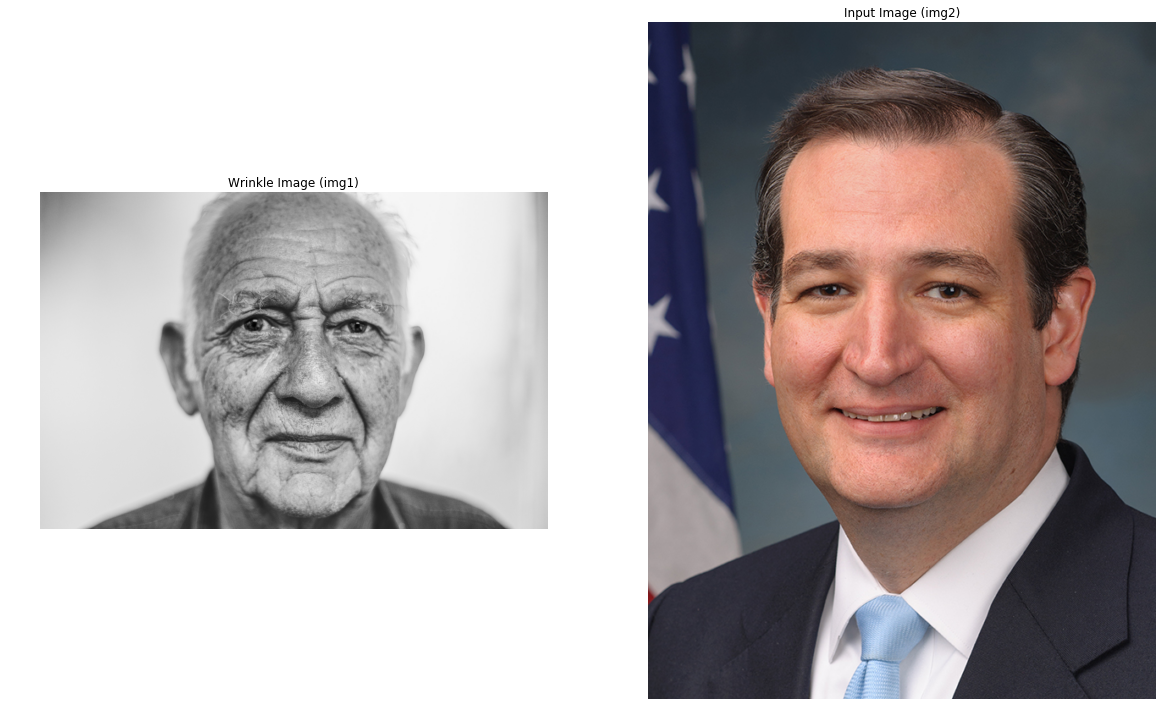

In [129]:
plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(img1[:,:,::-1])
plt.title("Wrinkle Image (img1)")
ax = plt.axis('off')

plt.subplot(122)
plt.imshow(img2[:,:,::-1])
plt.title("Input Image (img2)")
ax = plt.axis('off')

plt.show()


Find landmarks and guesstimate forehead points 

In [130]:
# Find landmarks
points1 = fbc.getLandmarks(faceDetector, landmarkDetector, img1)
points2 = fbc.getLandmarks(faceDetector, landmarkDetector, img2)

# Find forehead points
appendForeheadPoints(points1)
appendForeheadPoints(points2)

In [131]:
# Find Delaunay Triangulation
sizeImg1 = img1.shape
rect = (0, 0, sizeImg1[1], sizeImg1[0])
dt = fbc.calculateDelaunayTriangles(rect, points1)

Warp the wrinkle image to the input image one triangle at a time. 

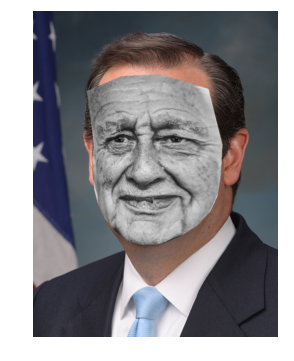

In [132]:
# Convert image for warping
img1 = np.float32(img1)/255.0
img2 = np.float32(img2)/255.0

# Warp wrinkle image to face image
img1Warped = np.copy(img2)
img1Warped = fbc.warpImage(img1, img1Warped, points1, points2, dt, useOutputImageSize=True)
img1Warped = np.uint8(img1Warped*255.0)
img2 = np.uint8(img2*255.0)

plt.imshow(img1Warped[:,:,::-1])
ax = plt.axis('off')
plt.show()

We do not want parts of the input image to be affected by the wrinkle image. So we create a mask where the eyes, mouth and nose regions are masked out.

The variable `clonedOutput` stores the results after seamless cloning. Noted we are using the `MIXED_CLONE` option because we just want the high gradient regions (wrinkles / spots etc.) from the wrinkle image.

In [133]:
# Calculate face mask for seamless cloning
mask = getFaceMask(img2.shape[0:2], points2)

# Seamlessly clone the wrinkle image onto original face
r1 = cv2.boundingRect(np.float32(points2))
# Bounding rectangle r1 has 4 elements: left(x1), top(y1), 
# width(w), height(h)
center1X = r1[0] + int(r1[2]/2.0)
center1Y = r1[1] + int(r1[3]/2.0)
center1 = (center1X, center1Y)
clonedOutput = cv2.seamlessClone(img1Warped, img2, 
                               mask, center1, 
                               cv2.MIXED_CLONE)

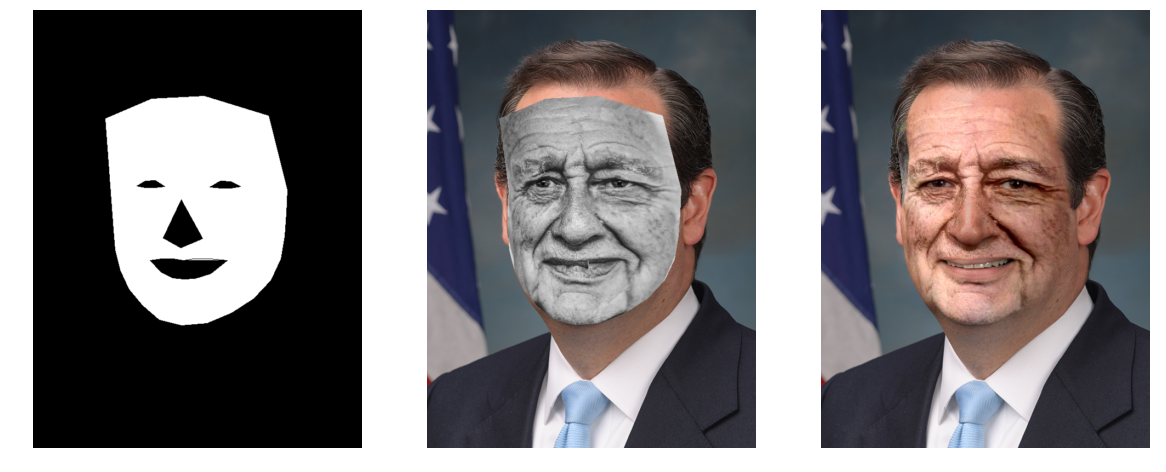

In [134]:
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(mask)
ax = plt.axis('off')


plt.subplot(132)
plt.imshow(img1Warped[:,:,::-1])
ax = plt.axis('off')


plt.subplot(133)
plt.imshow(clonedOutput[:,:,::-1])
ax = plt.axis('off')


plt.show()

When with seamless cloning, it is a good idea to blur the mask and use it to alpha blend the original image. This is because the mask is made out of polygons with sharp edges and these edges may show up in the final image.

The mask can be of any size. To apply a consistent blur, we can resize the mask to a constant size, apply a constant size blur on it, and then resize it back to the original size. Admittedly, this is a hack. One can argue that the right way is to apply a large blur kernel to the high resolution image. But doing so can be computationally expensive. Hence, this computationally cheap hack.

Also, notice we erode the mask slightly before blurring it. This is because we want the alpha to be near zero near the boundary of the seamless cloned region because the boundary has a sharp edge.

In [135]:
# Blurring face mask to alpha blend to hide seams
maskHeight, maskWidth = mask.shape[0:2]
maskSmall = cv2.resize(mask, (256, int(maskHeight*256.0/maskWidth)))
maskSmall = cv2.erode(maskSmall, (-1, -1), 25)
maskSmall = cv2.GaussianBlur(maskSmall, (51, 51), 0, 0)
mask = cv2.resize(maskSmall, (maskWidth, maskHeight))

Once the mask is blurred, we alpha blend the original image and the cloned image.



In [136]:
agedImage = alphaBlend(mask, clonedOutput, img2)

The blurred mask, cloned image and the alpha blended images are shown below. Note the sharp edge visible on the forehead in `clonedOutput` is much better blended in `agedImage`

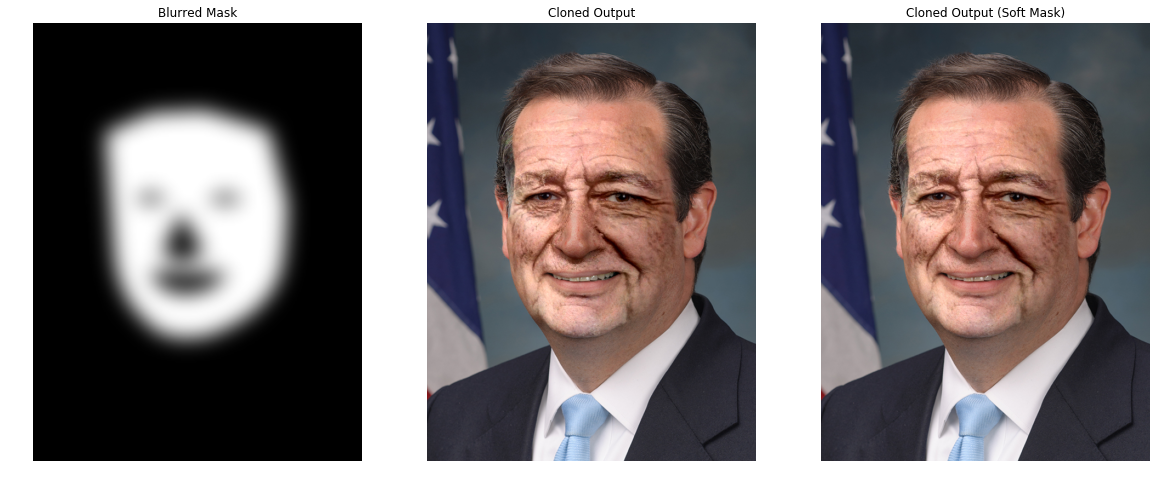

In [137]:
plt.figure(figsize=(20,20))

plt.subplot(131)
plt.imshow(mask)
plt.title("Blurred Mask")
ax = plt.axis('off')

plt.subplot(132)
plt.imshow(clonedOutput[:,:,::-1])
plt.title("Cloned Output")
ax = plt.axis('off')

plt.subplot(133)
plt.imshow(agedImage[:,:,::-1])
plt.title("Cloned Output (Soft Mask)")
ax = plt.axis('off')

plt.show()


Finally, we desaturate the final image. It has two effects. First, aging leads to a paler skin and desaturation simulates that effect. Second, the entire photo looks discolored and old. The overall effect is that we make the person look old and from an old time.

In [144]:
# Desaturate output
output = desaturateImage(agedImage, 0.8)

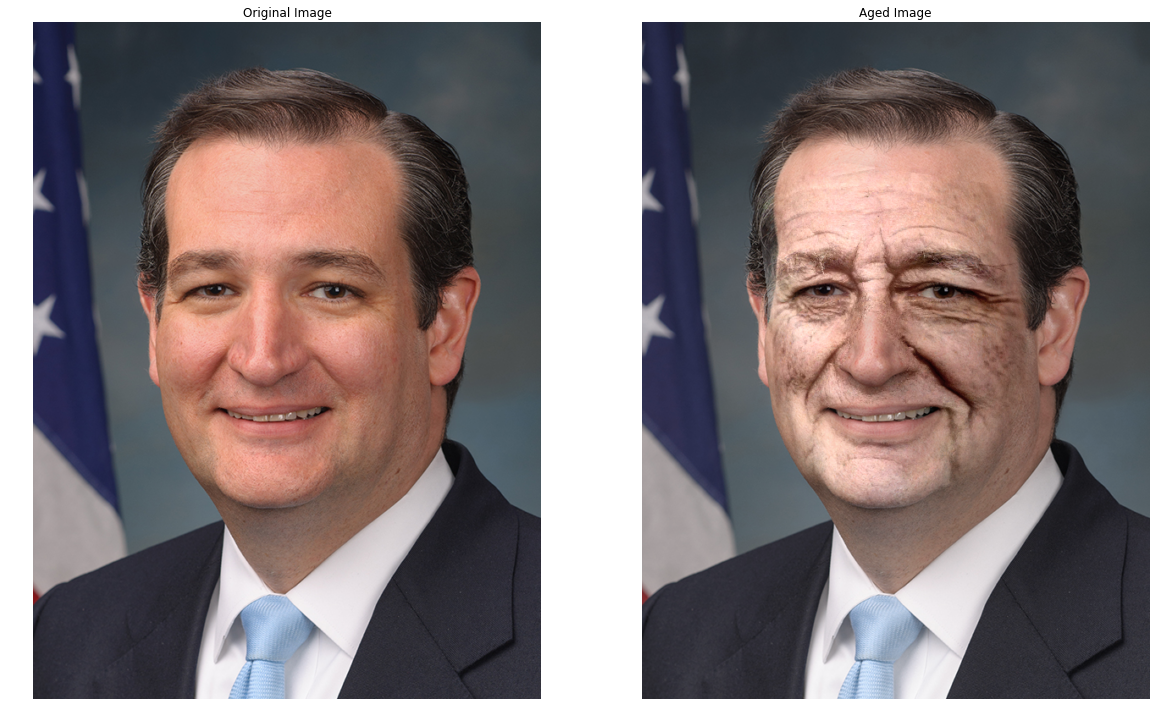

In [145]:
# Display results
plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(img2[:,:,::-1])
plt.title("Original Image")
plt.axis('off')

plt.subplot(122)
plt.imshow(output[:,:,::-1])
plt.title("Aged Image")
ax = plt.axis('off')
